<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
مسئله‌ی دوم: پیش بینی هزینه‌ی خانوار در حوزه‌ی حمل و نقل
</font>
</h1>
</p>

In [13]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import norm, expon, boxcox, shapiro
from sklearn.preprocessing import LabelEncoder , MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.ensemble import RandomForestRegressor  


In [14]:
# file names and directories
data_dir = '../Data/'
R_files = ['R98', 'R99', 'R1400', 'R1401']
U_files = ['U98', 'U99', 'U1400', 'U1401']
all_files = R_files + U_files

### Prep data

In [15]:
# extract feautres
def extract_features(files_list):
    features = []
    for file_name in files_list:
        # features
        data = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'Data'))
        data = pd.DataFrame(data)
        data = data[['Address', 'Fasl','province','town']]
        
        p1 = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'P1'))
        p1 = p1.groupby("Address")['member'].count().reset_index()
        p1 = pd.DataFrame(p1)
        
        data = data.merge(p1,on='Address')
        
        p2 = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'P2'))
        p2 = pd.DataFrame(p2)

        p2 = p2[['Address', 'vehicle', 'motorcycle', 'bicycle','tenure']]
 

        
        data = data.merge(p2,on='Address')
        
        p3 = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'P4S01'))
        p3 = pd.DataFrame(p3)

        p3 = p3[['Address','status_w','days_w','hours_w','netincome_w_y']]
        
        
        data = data.merge(p3,on = 'Address')
        
        p4 = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'P4S02'))
        p4 = pd.DataFrame(p4)

        p4 = p4[['Address','status_s','cost_employment']] 
        
        
        feature = data.merge(p4,on = 'Address')

        
        
        
        # target table
        p3s7 = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'P3S07'))
        p3s7 = p3s7.groupby("Address")['value'].sum().reset_index()
        
        # TODO: fix this merge because loses some records with no values in p3s7 table
        feature = feature.merge(p3s7,on='Address')
                
        feature['Year'] = file_name[1:] 
        feature['Region'] = feature['Address'].apply(lambda x: str(x)[1:5])
        
        features.append(feature)
        
    return features

In [16]:
yearly_features = extract_features(all_files)

In [17]:
features = pd.concat([feature for feature in yearly_features])

In [18]:
features.describe(include='all')

,Address,Fasl,province,town,member,vehicle,motorcycle,bicycle,tenure,status_w,days_w,hours_w,netincome_w_y,status_s,cost_employment,value,Year,Region
count,2.726600e+04,27266.000000,27266,27266.000000,27266.000000,27266,27266,27266,27266,27266.0,24085.0,24085.0,2.726600e+04,27264.000000,2.488300e+04,2.726600e+04,27266,27266
unique,NaN,NaN,31,NaN,NaN,2,2,2,7,7.0,16.0,37.0,NaN,NaN,NaN,NaN,4,410
top,NaN,NaN,Zanjan,NaN,NaN,True,False,False,OwnedEstateLand,3.0,6.0,8.0,NaN,NaN,NaN,NaN,98,1903
freq,NaN,NaN,3043,NaN,NaN,13651,14969,24269,24172,19985.0,6716.0,9917.0,NaN,NaN,NaN,NaN,7677,785
mean,1.850406e+10,2.462737,NaN,6.530918,4.392834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.393093e+08,5.092283,2.678964e+07,2.515447e+06,NaN,NaN
std,4.590238e+09,1.103030,NaN,5.591243,1.419047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.814960e+08,0.485260,2.408125e+08,3.232439e+06,NaN,NaN
min,1.000100e+10,1.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,4.000000,0.000000e+00,3.500000e+04,NaN,NaN
25%,1.250131e+10,1.000000,NaN,3.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.240000e+07,5.000000,0.000000e+00,9.000000e+05,NaN,NaN
50%,2.071647e+10,2.000000,NaN,5.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.500000e+08,5.000000,0.000000e+00,1.600000e+06,NaN,NaN
75%,2.190459e+10,3.000000,NaN,9.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.260000e+08,5.000000,0.000000e+00,3.000000e+06,NaN,NaN


In [19]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27266 entries, 0 to 1862
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Address          27266 non-null  int64  
 1   Fasl             27266 non-null  int64  
 2   province         27266 non-null  object 
 3   town             27266 non-null  int64  
 4   member           27266 non-null  int64  
 5   vehicle          27266 non-null  bool   
 6   motorcycle       27266 non-null  bool   
 7   bicycle          27266 non-null  bool   
 8   tenure           27266 non-null  object 
 9   status_w         27266 non-null  object 
 10  days_w           24085 non-null  object 
 11  hours_w          24085 non-null  object 
 12  netincome_w_y    27266 non-null  int64  
 13  status_s         27264 non-null  float64
 14  cost_employment  24883 non-null  float64
 15  value            27266 non-null  int64  
 16  Year             27266 non-null  object 
 17  Region           2

### Feature Engineering

In [20]:
# year column need to convert to labels
year_le = LabelEncoder()
features['Year'] = year_le.fit_transform(features['Year'])
label_encoder = LabelEncoder()
features['tenure'] = label_encoder.fit_transform(features['tenure'])
features['cost_employment'].fillna(features['cost_employment'].mean(),inplace=True) 
features['days_w'] = pd.to_numeric(features['days_w'], errors='coerce')  
features['days_w'] = features['days_w'].fillna(features['days_w'].mean()) 
features['hours_w'] = pd.to_numeric(features['hours_w'], errors='coerce')  
features['hours_w'] = features['hours_w'].fillna(features['hours_w'].mean())
features['status_w'] = pd.to_numeric(features['status_w'], errors='coerce') 
label_encoder = LabelEncoder()
features['province'] = label_encoder.fit_transform(features['province'])
min_max = MinMaxScaler()
features['cost_employment'] = min_max.fit_transform(features[['cost_employment']]) * 100
features = features.dropna(subset='status_w')
features = features.dropna(subset='status_s')


C:\Users\Abumahdi\AppData\Local\Temp\ipykernel_11060\1778933494.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features['cost_employment'].fillna(features['cost_employment'].mean(),inplace=True)


In [21]:
year_classes = year_le.classes_

# Create a mapping from encoded labels to original classes
label_mapping = {index: label for index, label in enumerate(year_classes)}

# Print the mapping
print(label_mapping)

{0: '1400', 1: '1401', 2: '98', 3: '99'}


In [22]:
# province column need to convert to labels
region_le = LabelEncoder()
features['Region'] = region_le.fit_transform(features['Region'])


In [23]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27262 entries, 0 to 1862
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Address          27262 non-null  int64  
 1   Fasl             27262 non-null  int64  
 2   province         27262 non-null  int32  
 3   town             27262 non-null  int64  
 4   member           27262 non-null  int64  
 5   vehicle          27262 non-null  bool   
 6   motorcycle       27262 non-null  bool   
 7   bicycle          27262 non-null  bool   
 8   tenure           27262 non-null  int32  
 9   status_w         27262 non-null  float64
 10  days_w           27262 non-null  float64
 11  hours_w          27262 non-null  float64
 12  netincome_w_y    27262 non-null  int64  
 13  status_s         27262 non-null  float64
 14  cost_employment  27262 non-null  float64
 15  value            27262 non-null  int64  
 16  Year             27262 non-null  int32  
 17  Region           2

In [24]:
features.head()

,Address,Fasl,province,town,member,vehicle,motorcycle,bicycle,tenure,status_w,days_w,hours_w,netincome_w_y,status_s,cost_employment,value,Year,Region
0,20001384020,3,22,1,4,False,False,False,0,3.0,6.000000,8.00000,135000000,5.0,0.196078,900000,2,0
1,20001384020,3,22,1,4,False,False,False,0,3.0,5.000000,8.00000,60000000,5.0,0.196078,900000,2,0
2,20001384109,4,22,1,4,False,True,False,4,3.0,6.000000,8.00000,194480004,5.0,0.262644,1800000,2,0
3,20001384111,4,22,1,4,False,True,False,4,3.0,4.906676,7.65688,60000000,5.0,0.262644,1100000,2,0
4,20001384123,4,22,1,3,True,False,True,0,3.0,3.000000,8.00000,60000000,4.0,0.166667,9600000,2,0


### Train Model

In [25]:
# split train test data
# Note: Winter 1401 is test data
test = features[(features['Year'] == 1) & (features['Fasl'] == 4)]
train = features[~((features['Year'] == 1) & (features['Fasl'] == 4))]
test.shape, train.shape

((1304, 18), (25958, 18))

In [26]:
X_train = train.drop(['Address', 'value'], axis=1)
y_train = train['value']

X_test = test.drop(['Address', 'value'], axis=1)
y_test = test['value']

In [27]:
# new we train data
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

LinearRegression()

Mean Squared Error: 16367619886908.838
R-squared: 0.0715770278057446


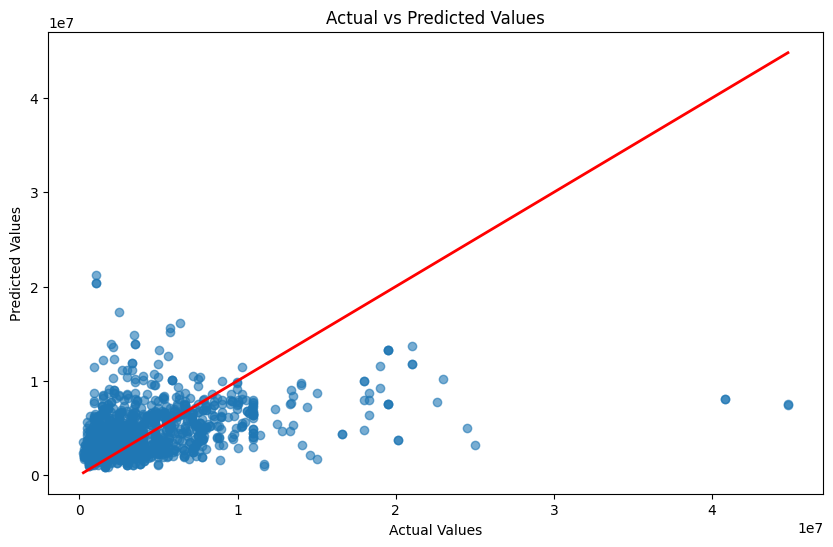

In [28]:
#use another model : randomforestregressor : 
from sklearn.ensemble import RandomForestRegressor  

model = RandomForestRegressor(n_estimators=100, random_state=42)  
model.fit(X_train, y_train)  
y_pred = model.predict(X_test)  

mse = mean_squared_error(y_test, y_pred)  
r_squared = r2_score(y_test, y_pred)  
print(f'Mean Squared Error: {mse}')  
print(f'R-squared: {r_squared}')
#visualise it : 
plt.figure(figsize=(10, 6))  
plt.scatter(y_test, y_pred, alpha=0.6)  
plt.xlabel('Actual Values')  
plt.ylabel('Predicted Values')  
plt.title('Actual vs Predicted Values')  
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  
plt.show()

Mean Squared Error: 14481424583205.19
R-squared: 0.17856796858412993


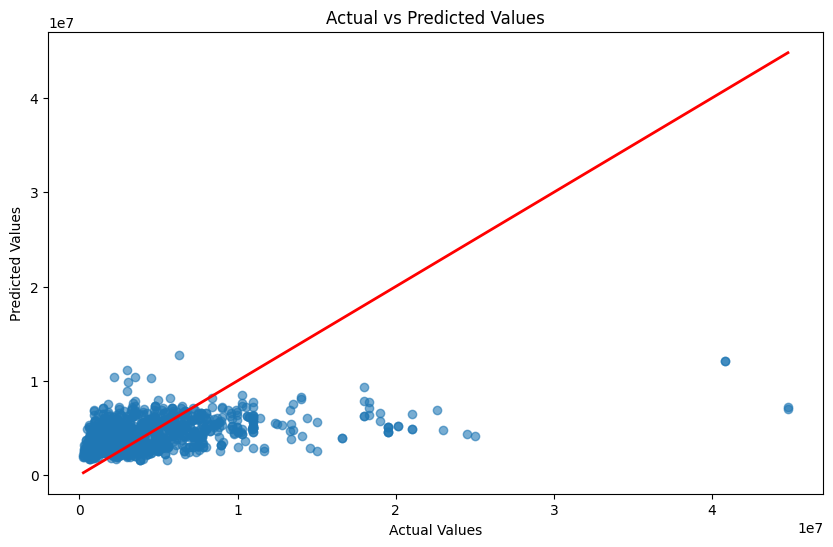

In [29]:
#using gradientboostingregressor : 
from sklearn.ensemble import GradientBoostingRegressor  

model = GradientBoostingRegressor(n_estimators=100, random_state=42)  
model.fit(X_train, y_train)  
y_pred = model.predict(X_test)  

mse = mean_squared_error(y_test, y_pred)  
r_squared = r2_score(y_test, y_pred)  
print(f'Mean Squared Error: {mse}')  
print(f'R-squared: {r_squared}')
#visualise it : 
plt.figure(figsize=(10, 6))  
plt.scatter(y_test, y_pred, alpha=0.6)  
plt.xlabel('Actual Values')  
plt.ylabel('Predicted Values')  
plt.title('Actual vs Predicted Values')  
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  
plt.show()

Mean Squared Error: 15449537065491.926
R-squared: 0.12365357819424172


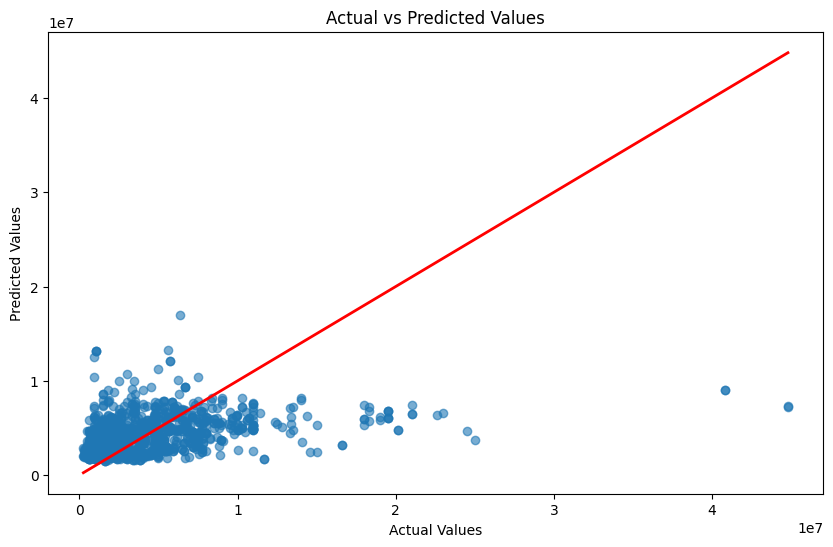

In [30]:
#use gridsearch
from sklearn.model_selection import GridSearchCV  

param_grid = {  
    'n_estimators': [100, 200],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5, 10]  
}  

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')  
grid_search.fit(X_train, y_train)  
best_model = grid_search.best_estimator_  

y_pred = best_model.predict(X_test)  

mse = mean_squared_error(y_test, y_pred)  
r_squared = r2_score(y_test, y_pred)  
print(f'Mean Squared Error: {mse}')  
print(f'R-squared: {r_squared}')
#visualise it : 
plt.figure(figsize=(10, 6))  
plt.scatter(y_test, y_pred, alpha=0.6)  
plt.xlabel('Actual Values')  
plt.ylabel('Predicted Values')  
plt.title('Actual vs Predicted Values')  
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  
plt.show()


### Test Model

In [ ]:
y_pred = model.predict(X_test_poly)  

# test model with mse for linear regresson 
mse = mean_squared_error(y_test, y_pred)  
print(f'Mean Squared Error: {mse}')  

r_squared = model.score(X_test_poly, y_test)  
print(f'R-squared: {r_squared}') 
print("r2_score is :",r2_score(y_test,y_pred)) 

# visualise it  
plt.figure(figsize=(10, 6))  
plt.scatter(y_test, y_pred, alpha=0.6)  
plt.xlabel('Actual Values')  
plt.ylabel('Predicted Values')  
plt.title('Actual vs Predicted Values')  
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # Line for perfect prediction  
plt.show()